# $\theta$ Maps (IN PROGRESS)

## 1 - Libraries 

In [1]:
# MODULE                                             # DESCRIPTION
import numpy as np                                   # scientific computing
import numpy.ma as ma                                # numpy masked arrays
import pandas as pd                                  # data analysis and manipulation
import geopandas as gpd                              # geospatial data analysis
import utm                                           # bidirectional UTM-WGS84 converter
import folium                                        # interactive data visualization
import re                                            # regular expressions
from osgeo import gdal, gdalconst                    # raster and geospatial data proc.
import rasterio as rs                                # raster and geospatial data proc.
import matplotlib.pyplot as plt                      # create visualizations
import seaborn as sns                                # create visualizations
import datetime                                      # datetime manipulation
import glob                                          # unix pathname expansion
import haversine as hs                               # distances between points
import dask                                          # parallel computing
from dask.distributed import Client                  # set custom parameters in cluster
import dask.dataframe as dd                          # manipulation of lazy dask dfs
import datashader as ds                              # visualization for big data
from sklearn import linear_model                     # regression 
from sklearn.metrics import mean_absolute_error      # to compute MAE
from sklearn.metrics import mean_squared_error       # to compute RMSE
from sklearn.metrics import r2_score                 # to compute R^2
import xarray as xr                                  # efficent ND arrays manipulation
import rioxarray                                     # rasterio xarray extension
import colorcet as cc                                # colormaps for datashader 
from matplotlib.colors import LinearSegmentedColormap# create custom color maps
from shapely import geometry                         # manipulate planar features
from shapely.geometry import Point                   # manipulate planar features
import pickle                                        # load/save pickle datasets
import os                                            # miscellaneous OS interfaces
from pathlib import Path                             # 
import math                                          #
import random      

## 2 -  Functions

In [2]:
edge_dry_intercept = (0, -0.5)
edge_dry_slope = 3

edge_wet_intercept = (0, 4)
edge_wet_slope = 11



def computeW_by_px(ndvi, str_,
                   i_d = edge_dry_intercept, 
                   s_d = edge_dry_slope,
                   i_w = edge_wet_intercept,
                   s_w = edge_wet_slope) : 

    STRd = STR_f(intercept = i_d,
                 slope = s_d,
                 ndvi = ndvi)
    STRw = STR_f(intercept = i_w,
                 slope = s_w,
                 ndvi = ndvi)
    w  = W(STRd, STRw, STR)

    # fix saturated values
    w = xr.where(cond = w > 1, x = 1, y = w)
    w = xr.where(cond = w < 0, x = 0, y = w)
    
    return(w)


def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt


def S2_getIndex(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except AttributeError: 
        print('Error: File with pattern %s not found' % pattern)
        
def W(STRd, STRw, STR):
    return((STR - STRd)/(STRw - STRd))

def STR_f(slope, ndvi, intercept):
    intercept_x  = intercept[0]
    intercept_y  = intercept[1]
    return (slope*(ndvi - intercept_x) + intercept_y) # y = m(x-x1) + y1



colors = ["red", "darkorange", "yellow", "palegreen", "springgreen", "cyan", "blue"]
custom_cmap_w = LinearSegmentedColormap.from_list("mycmap", colors)

## 3 - $W$ Maps

### 3.1 -  Computation  

In [3]:
BASE_DIR = './'
BASE_DIR_BOA = os.path.join(BASE_DIR, 'sen2r/out/BOA2/')
BASE_DIR_SCL = os.path.join(BASE_DIR, 'sen2r/out/SCL/')
BASE_DIR_NDVI = os.path.join(BASE_DIR, 'sen2r/indices/NDVI/')

BASE_DIR_W_maps = os.path.join(BASE_DIR, 'W_maps')
BASE_DIR_W_maps_masked =  os.path.join(BASE_DIR_W_maps, 'masked')

Path(BASE_DIR_W_maps).mkdir(parents=True, exist_ok=True)
Path(BASE_DIR_W_maps_masked).mkdir(parents=True, exist_ok=True)

Optra global parametrization: 

In [4]:
if True : 
    boa_files = [f for f in os.listdir(BASE_DIR_BOA,) if os.path.isfile(os.path.join(BASE_DIR_BOA, f))]

    for idx, boa_fp in enumerate(boa_files) : 

        try : 
            now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
            print('[%s] : processing file (%s/%s) %s... \n' % (now, idx, len(boa_files), boa_fp))
            boa_fp = BASE_DIR_BOA + boa_fp
            raster_date = S2_getDate(boa_fp)
            scl_fp = S2_getIndex("./sen2r/out/SCL_res10/", raster_date)
            ndvi_fp = S2_getIndex(BASE_DIR_NDVI, raster_date)

            scl = rioxarray.open_rasterio(scl_fp, masked=True)
            scl = scl[0]
            scl = scl.rename({'band':'scl'})

            ndvi = rioxarray.open_rasterio(ndvi_fp, masked=True)
            ndvi = ndvi[0]
            ndvi = ndvi.rename({'band':'ndvi'})

            boa  = rioxarray.open_rasterio(boa_fp, masked=True)
            swir = boa[10]/10000
            swir = swir.rename({'band':'STR'})

            STR  = ((1-swir)**2)/(2*swir)

            w = computeW_by_px(ndvi, STR,
                               i_d = edge_dry_intercept, 
                               s_d = edge_dry_slope,
                               i_w = edge_wet_intercept,
                               s_w = edge_wet_slope)

            w_masked = w.where(
                                (scl == 4) | # vegetation
                                (scl == 5) | # not_vegetated
                                (scl == 6)   # water
                              )

            w_fp = boa_fp[len(BASE_DIR_BOA):-11]+"_W.tif"
            w.rio.to_raster(os.path.join(BASE_DIR_W_maps, w_fp))
            w_masked.rio.to_raster(os.path.join(BASE_DIR_W_maps_masked, w_fp))

        except Exception as e :
            print("An error occurred while processing data for file %s " % boa_fp)
            print("Original message: %s " % e)

[2022/05/06 12:14:03] : processing file (0/74) S2A2A_20190415_041_Walnut-Gulch_BOA_10.tif... 

[2022/05/06 12:14:03] : processing file (1/74) S2A2A_20190115_041_Walnut-Gulch_BOA_10.tif... 

An error occurred while processing data for file ./sen2r/out/BOA2/S2A2A_20190115_041_Walnut-Gulch_BOA_10.tif 
Original message: list index out of range 
[2022/05/06 12:14:03] : processing file (2/74) S2B2A_20191027_041_Walnut-Gulch_BOA_10.tif... 

[2022/05/06 12:14:04] : processing file (3/74) S2B2A_20190619_041_Walnut-Gulch_BOA_10.tif... 

[2022/05/06 12:14:04] : processing file (4/74) S2A2A_20191012_041_Walnut-Gulch_BOA_10.tif... 

[2022/05/06 12:14:04] : processing file (5/74) S2B2A_20191126_041_Walnut-Gulch_BOA_10.tif... 

[2022/05/06 12:14:05] : processing file (6/74) S2B2A_20190808_041_Walnut-Gulch_BOA_10.tif... 

[2022/05/06 12:14:05] : processing file (7/74) S2A2A_20191211_041_Walnut-Gulch_BOA_10.tif... 

[2022/05/06 12:14:05] : processing file (8/74) S2A2A_20190306_041_Walnut-Gulch_BOA_10.t

### 3.2 -  Visualization  


[]

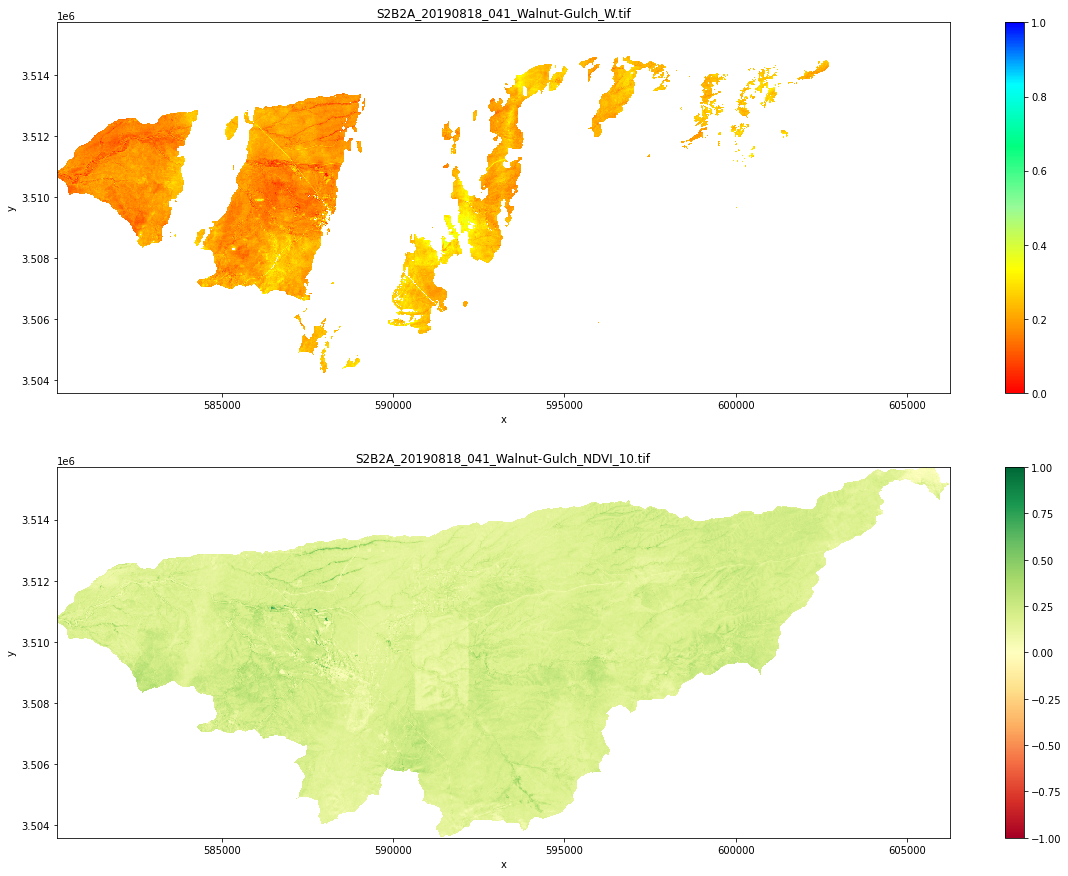

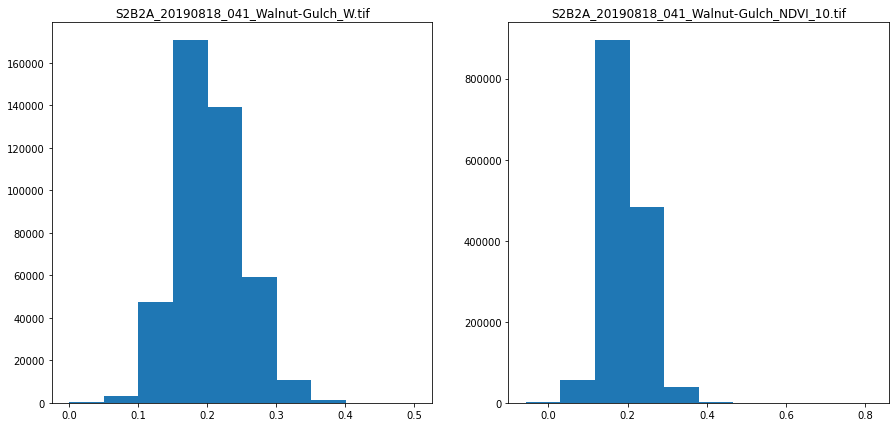

In [5]:
file_idx = 4

w_files = [f for f in os.listdir(BASE_DIR_W_maps) if os.path.isfile(os.path.join(BASE_DIR_W_maps, f))]
ndvi_file = w_files[file_idx][:-5]+ "NDVI_10.tif"
custom_cmap_ndvi = "RdYlGn"

w = rioxarray.open_rasterio(os.path.join(BASE_DIR_W_maps,
                                         w_files[file_idx]), 
                            masked=True)

w_masked = rioxarray.open_rasterio(os.path.join(BASE_DIR_W_maps_masked,
                                         w_files[file_idx]), 
                            masked=True)

ndvi = rioxarray.open_rasterio(os.path.join(BASE_DIR_NDVI,
                                            ndvi_file), 
                            masked=True)

fig, axs = plt.subplots(2,1, figsize = (20,15))
w_masked.plot(ax = axs[0], cmap = custom_cmap_w, vmin = 0, vmax = 1)
ndvi.plot(ax = axs[1], cmap = custom_cmap_ndvi, vmin = -1, vmax = 1)
axs[0].title.set_text(w_files[file_idx])
axs[1].title.set_text(ndvi_file)


fig, axs = plt.subplots(1,2, figsize = (15,7))
w_masked.plot.hist(ax = axs[0])
ndvi.plot.hist(ax = axs[1])
axs[0].title.set_text(w_files[file_idx])
axs[1].title.set_text(ndvi_file)
plt.plot()


## 4 - $\theta$ Maps 

#### 3.2.1 - Global $\theta_d$ $\theta_w$ 

In [6]:
BASE_DIR_theta_maps = os.path.join(BASE_DIR, 'theta_maps')
BASE_DIR_theta_maps_masked =  os.path.join(BASE_DIR_theta_maps, 'masked')


Path(BASE_DIR_theta_maps).mkdir(parents=True, exist_ok=True)
Path(BASE_DIR_theta_maps_masked).mkdir(parents=True, exist_ok=True)

In [7]:
with open('./inSitu_dfs_global_masked.pkl', 'rb') as f:
    inSitu_dfs_global_masked = pickle.load(f)

In [8]:
inSitu_dfs_global_masked.head()

,ndvi,str,utm_x,utm_y,fpath,scl_value,dist,sensor_name,SM5,theta_d,theta_w,str_d,str_w,W,theta_d_reg,theta_w_reg,SM5_hat,SM5_hat_reg
datetime,,,,,,,,,,,,,,,,,,
2019-01-20 18:06:49,0.137255,1.131776,586115.0,3510185.0,./sen2r/out/BOA2/S2B2A_20190120_041_Walnut-Gul...,5.0,4.991329,rg13vt19,20.0,4.0,37.0,-0.088235,5.509804,0.217935,-0.921979,88.718477,11.191870,18.613856
2019-01-25 18:06:31,0.120135,1.295199,586115.0,3510185.0,./sen2r/out/BOA2/S2A2A_20190125_041_Walnut-Gul...,5.0,4.991329,rg13vt19,19.0,4.0,37.0,-0.139594,5.321489,0.262731,-0.921979,88.718477,12.670108,22.629307
2019-01-30 18:06:09,0.125749,1.614491,586115.0,3510185.0,./sen2r/out/BOA2/S2B2A_20190130_041_Walnut-Gul...,5.0,4.991329,rg13vt19,19.0,4.0,37.0,-0.122755,5.383234,0.315519,-0.921979,88.718477,14.412134,27.361307
2019-02-04 18:05:31,0.105996,1.037364,586115.0,3510185.0,./sen2r/out/BOA2/S2A2A_20190204_041_Walnut-Gul...,5.0,4.991329,rg13vt19,18.0,4.0,37.0,-0.182013,5.165953,0.228008,-0.921979,88.718477,11.524253,19.516731
2019-03-01 18:02:49,0.125536,1.057225,586115.0,3510185.0,./sen2r/out/BOA2/S2B2A_20190301_041_Walnut-Gul...,5.0,4.991329,rg13vt19,24.0,4.0,37.0,-0.123391,5.380901,0.214490,-0.921979,88.718477,11.078170,18.305003


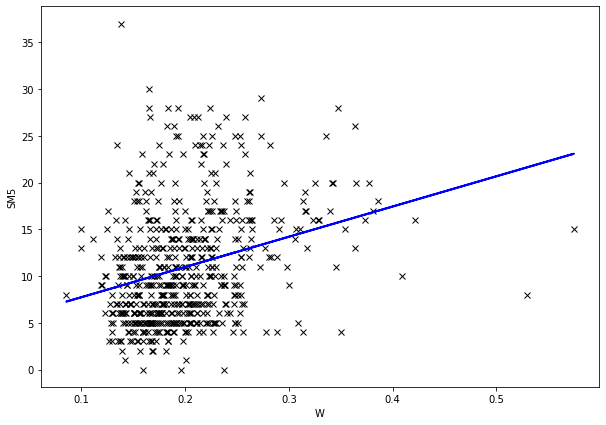

In [9]:
dataset = inSitu_dfs_global_masked
dataset = dataset.dropna()
X = dataset["W"].values.reshape(-1,1)
y = dataset["SM5"].values.reshape(-1,1)

lm = linear_model.LinearRegression()
lm.fit(X, y)
theta_d_reg = lm.predict([[0]]) # W = 0
theta_w_reg = lm.predict([[1]]) # W = 1

fig, axs = plt.subplots(1,1, figsize = (10, 7))
axs.plot(inSitu_dfs_global_masked["W"], inSitu_dfs_global_masked["SM5"], 'kx')
axs.plot(X, lm.predict(X), color="blue", linewidth=2)
plt.xlabel("W")
plt.ylabel("SM5")
plt.show()

In [10]:
print("theta_d = %d, theta_w = %d"%(theta_d_reg, theta_w_reg))

theta_d = 4, theta_w = 36


$$\theta = W\cdot(\theta_w - \theta_d) + \theta_d$$

In [11]:
#theta_fp = w_fp[len(BASE_DIR_theta_maps)+1:-5]+"_theta.tif"
theta_fp = w_fp[:-5]+"theta.tif"
theta_fp

'S2B2A_20190311_041_Walnut-Gulch_theta.tif'

In [12]:
if True : 
    w_files = [f for f in os.listdir(BASE_DIR_W_maps) if os.path.isfile(os.path.join(BASE_DIR_W_maps, f))]

    for idx, w_fp in enumerate(w_files) : 

        try : 
            now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
            print('[%s] : processing file (%s/%s) %s... \n' % (now, idx, len(w_files), w_fp))
            w  = rioxarray.open_rasterio(os.path.join(BASE_DIR_W_maps, w_fp), masked=True)
            theta = w*(theta_w_reg - theta_d_reg) + theta_d_reg
            
            w_masked = rioxarray.open_rasterio(os.path.join(BASE_DIR_W_maps_masked, w_fp), masked=True)
            theta_masked = w_masked*(theta_w_reg - theta_d_reg) + theta_d_reg

            theta_fp = w_fp[:-5]+"theta.tif"
            theta.rio.to_raster(os.path.join(BASE_DIR_theta_maps, theta_fp))
            theta_masked.rio.to_raster(os.path.join(BASE_DIR_theta_maps_masked, theta_fp))

            #w_masked.rio.to_raster(os.path.join(BASE_DIR_W_maps_masked, w_fp))

        except Exception as e :
            print("An error occurred while processing data for file %s " % w_fp)
            print("Original message: %s " % e)

[2022/05/06 12:14:29] : processing file (0/71) S2A2A_20191211_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (1/71) S2A2A_20190614_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (2/71) S2B2A_20190510_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (3/71) S2A2A_20190823_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (4/71) S2B2A_20190818_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (5/71) S2A2A_20190704_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (6/71) S2A2A_20191201_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (7/71) S2B2A_20190907_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (8/71) S2B2A_20191216_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:29] : processing file (9/71) S2B2A_20190110_041_Walnut-Gulch_W.tif... 

[2022/05/06 12:14:30] : processing file (10/71) S2B2A_20190311_041_Walnut-Gulch_W.tif... 

[2022/05/

[]

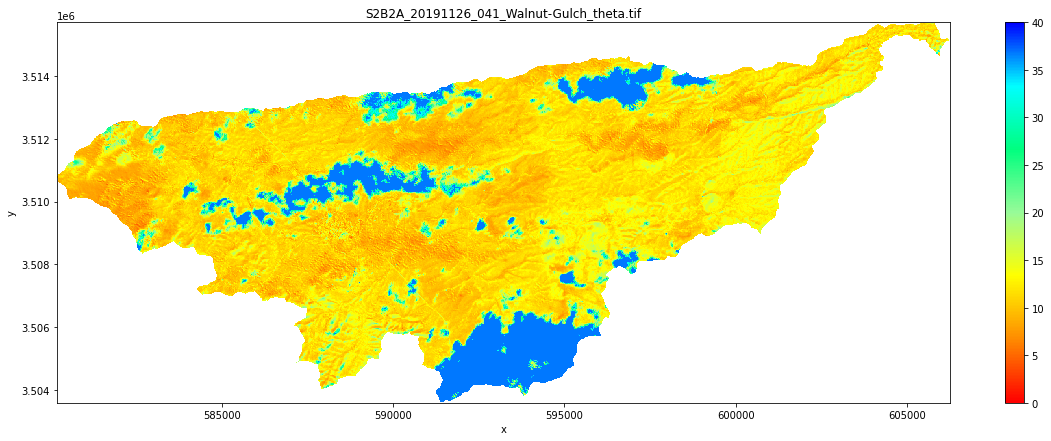

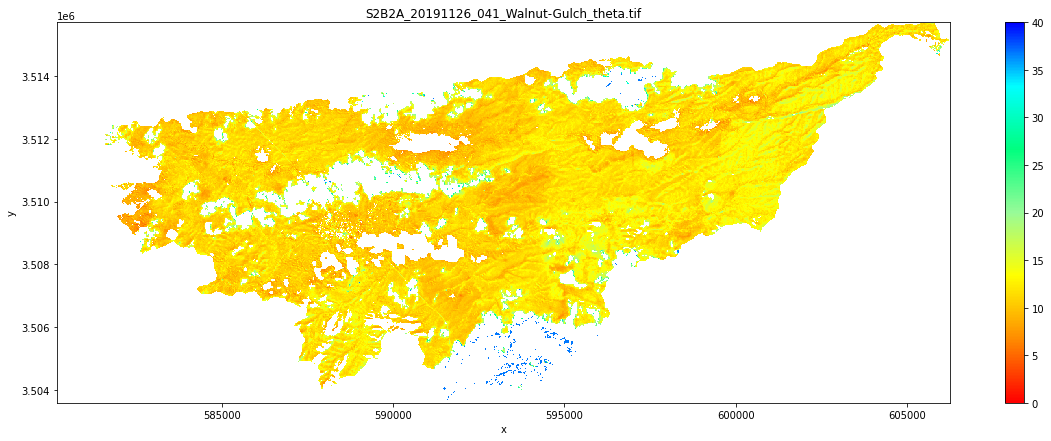

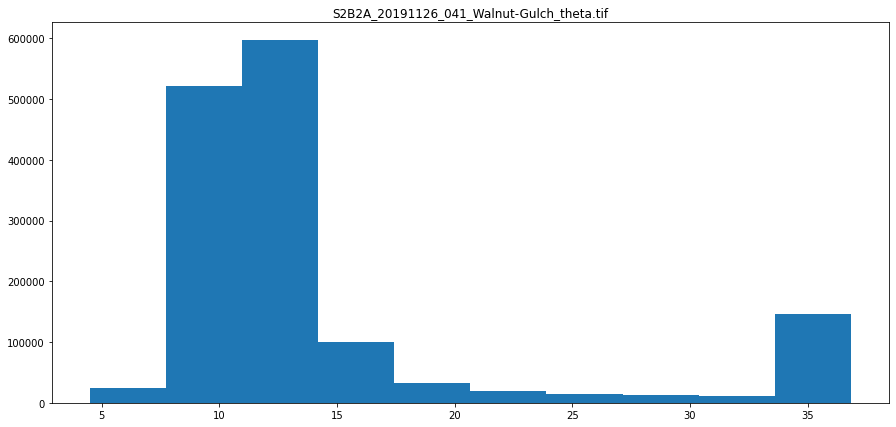

In [13]:
file_idx = 45

theta_files = [f for f in os.listdir(BASE_DIR_theta_maps) if os.path.isfile(os.path.join(BASE_DIR_theta_maps, f))]
custom_cmap_ndvi = "RdYlGn"

theta = rioxarray.open_rasterio(os.path.join(BASE_DIR_theta_maps,
                                             theta_files[file_idx]), 
                            masked=True)

theta_masked = rioxarray.open_rasterio(os.path.join(BASE_DIR_theta_maps_masked,
                                         theta_files[file_idx]), 
                           masked=True)


fig, axs = plt.subplots(1,1, figsize = (20,7))
theta.plot(ax = axs, cmap = custom_cmap_w, vmin = 0, vmax = 40)
axs.title.set_text(theta_files[file_idx])


fig, axs = plt.subplots(1,1, figsize = (20,7))
theta_masked.plot(ax = axs, cmap = custom_cmap_w, vmin = 0, vmax = 40)
axs.title.set_text(theta_files[file_idx])

fig, axs = plt.subplots(1,1, figsize = (15,7))
theta.plot.hist(ax = axs)
axs.title.set_text(theta_files[file_idx])

plt.plot()

###  Voronoi approach  (IN PROGRESS)

In [14]:
from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from shapely.geometry import Point

swrc_wg = gpd.read_file('./WG-boundary/boundary/boundary.shp')

sensor_coords_utm = {'rg13vt19'  : [586110, 3510185],
                     'rg14vt19'  : [585442, 3507187],
                     #'rg18vt19'  : [586710, 3508098],
                     'rg20vt19'  : [587480, 3504939],
                     'rg28vt19'  : [590624, 3509990],
                     'rg34vt19'  : [590946, 3507458],
                     'rg37vt19'  : [593303, 3506068],
                     'rg40vt19'  : [593360, 3510286],
                     'rg46vt19'  : [595289, 3508655],
                     'rg57vt19'  : [596089, 3510781],
                     'rg69vt19'  : [603916, 3515463],
                     'rg70vt19'  : [604288, 3514207],
                     'rg76vt19'  : [582624, 3509679],
                     'rg82vt19'  : [600154, 3511680],
                     'rg83vt19'  : [589679, 3512426],
                     'rg89vt19'  : [596308, 3513931],
                     'rg92vt19'  : [581888, 3511774],
                     'rg100vt19' : [593266, 3504720]
}
coords = np.array(list(sensor_coords_utm.values()))
area_shape  = swrc_wg.geometry[0]

In [15]:
region_polys, region_pts = voronoi_regions_from_coords(coords, area_shape)

In [16]:
region_polys

{0: <shapely.geometry.polygon.Polygon at 0x7fdcb90cbc70>,
 1: <shapely.geometry.multipolygon.MultiPolygon at 0x7fdcb90cbe20>,
 2: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb1c0>,
 3: <shapely.geometry.polygon.Polygon at 0x7fdcb90cba90>,
 4: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb850>,
 5: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb9a0>,
 6: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb820>,
 7: <shapely.geometry.polygon.Polygon at 0x7fdcb90cbca0>,
 8: <shapely.geometry.polygon.Polygon at 0x7fdcb90cbeb0>,
 9: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb880>,
 10: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb970>,
 11: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb130>,
 12: <shapely.geometry.polygon.Polygon at 0x7fdcb90cbfd0>,
 13: <shapely.geometry.multipolygon.MultiPolygon at 0x7fdcb90cbfa0>,
 14: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb100>,
 15: <shapely.geometry.polygon.Polygon at 0x7fdcb90cb790>,
 16: <shapely.geometry.polygon.Polygon at 0x7f

/home/vyago/miniconda3/envs/optram/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/vyago/miniconda3/envs/optram/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


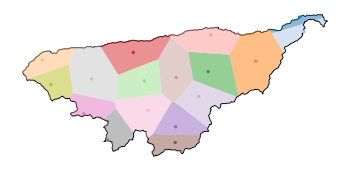

In [17]:
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, area_shape, region_polys, coords, region_pts)
plt.show()

In [18]:
# Check to wich voronoi_area a point belongs
[ voronoi_areas.contains(Point(sensor_coords_utm["rg13vt19"])) for voronoi_areas in region_polys.values()]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False]

### 4.1 - Computation

### 4.2 - Visualization 